<a href="https://colab.research.google.com/github/lindsaygross/ReinforcementLearning/blob/main/Lindsay_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4 - Lindsay
## CartPole with Value-Based Agents (DQN Variants)

Objectives:
1. Train a **baseline DQN** on CartPole using **RL Zoo 3** (a training harness around Stable-Baselines3).
2. Diagnose **stability** by inspecting learning curves and evaluation performance.
3. Implement and train **Dueling DQN** (an architecture change) using Stable-Baselines3 directly.
4. On your own, implemnet **Double DQN**




Run on Google Colab:

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/duke-trust-lab/intro_modern_rl/blob/main/lab4/lab4.ipynb)

In [ ]:
%pip install -q stable-baselines3==2.* sb3-contrib==2.* gymnasium matplotlib pandas pyyaml imageio ffmpeg-python
%pip install -q rl_zoo3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.0/188.0 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.3/566.3 kB 53.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transformers 5.0.0 requires huggingface-hub<2.0,>=1.3.0, but you have huggingface-hub 0.36.1 which is incompatible.


In [ ]:
import os
import glob
import time
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import Video, display

import gymnasium as gym
import torch

### What DQN is doing

DQN learns an approximation of the action-value function:

Qθ(s,a)

A standard DQN target is:

y = r + γ max_a' Qθ⁻(s', a')

where:
- θ: online network parameters (updated every gradient step)
- θ⁻: target network parameters (updated more slowly)

DQN typically uses:
- **experience replay**: sample random mini-batches from a replay buffer (reduces correlation)
- **target network**: stabilizes the moving target in TD learning
- **ε-greedy exploration**: balance exploration vs exploitation

---

## Why use RL Zoo 3 for the baseline run?

RL Zoo provides:
- a clean, repeatable CLI training workflow
- standardized logging + saved best models
- video recording utilities

This lets us focus on:
- what the hyperparameters mean
- what the training curves tell us
- how evaluation differs from training


### Create RL Zoo YAML config for baseline DQN

In [ ]:
ENV_ID = "CartPole-v1"
LOG_DIR = "logs"

os.makedirs(LOG_DIR, exist_ok=True)

dqn_config = {
    ENV_ID: {
        "policy": "MlpPolicy",
        "n_timesteps": float(6e4),
        "buffer_size": 20000,
        "learning_starts": 1000,
        "target_update_interval": 250,
        "exploration_fraction": 0.2,
        "exploration_final_eps": 0.06,
        "learning_rate": float(1e-3),
        "batch_size": 64,
        "train_freq": 32,
        "gradient_steps": 16,
        "gamma": 0.99,
        "optimize_memory_usage": False,
    }
}

with open("dqn_base.yaml", "w") as f:
    yaml.safe_dump(dqn_config, f, sort_keys=False)

print("Wrote dqn_base.yaml")

Wrote dqn_base.yaml


In [ ]:
# Train a single baseline run (seed 0). You can later expand to multiple seeds.
seed = 0
cmd = f"python -m rl_zoo3.train --algo dqn --env {ENV_ID} -f {LOG_DIR}/ -c dqn_base.yaml --log-interval 1000 --seed {seed}"
print("Running:", cmd)
!{cmd}

Running: python -m rl_zoo3.train --algo dqn --env CartPole-v1 -f logs/ -c dqn_base.yaml --log-interval 1000 --seed 0
2026-02-04 00:50:58.390332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770166258.426730    3254 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770166258.450570    3254 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770166258.475467    3254 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770166258.475500    3254 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking th

In [ ]:
cmd = f"""python -m rl_zoo3.record_video \
  --algo dqn \
  --env {ENV_ID} \
  --folder {LOG_DIR}/ \
  -n 600 \
  --deterministic \
  --load-best
"""
print("Running:", cmd)
!{cmd}

Running: python -m rl_zoo3.record_video   --algo dqn   --env CartPole-v1   --folder logs/   -n 600   --deterministic   --load-best

2026-02-04 00:53:06.913386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770166386.932935    3840 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770166386.938750    3840 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770166386.954090    3840 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770166386.954115    3840 computation_placer.cc:177] computation placer already registered. Please check linkage and a

In [ ]:
mp4s = glob.glob(os.path.join(LOG_DIR, "**", "*.mp4"), recursive=True)
mp4s_sorted = sorted(mp4s, key=os.path.getmtime, reverse=True)
print("Found videos:", len(mp4s_sorted))

if mp4s_sorted:
    print("Showing:", mp4s_sorted[0])
    display(Video(mp4s_sorted[0], embed=True))

Found videos: 1
Showing: logs/dqn/CartPole-v1_1/videos/best-model-dqn-CartPole-v1-step-0-to-step-600.mp4


## Diagnosing value estimation instability

In deep value-based RL, instability can show up as:
- learning curves that spike then collapse
- large oscillations in evaluation returns
- sensitivity to seed / hyperparameters
- apparently “good” training signals that don’t transfer to evaluation behavior



### Dueling DQN

Dueling DQN explicitly decomposes:

Q(s,a) = V(s) + A(s,a) − mean_a A(s,a)

Intuition:
- V(s): how good is the state (regardless of action)?
- A(s,a): how much better is action a compared to other actions in state s?

This can help in environments where:
- many actions have similar value
- learning V(s) is easier than learning full Q(s,a) directly

We will implement a custom DQN policy with dueling heads.


In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback

SB3_LOG_BASE = "sb3_logs"
os.makedirs(SB3_LOG_BASE, exist_ok=True)

def make_env(env_id="CartPole-v1"):
    env = gym.make(env_id)
    env = Monitor(env)
    return env

def train_sb3(
    name: str,
    policy,
    env_id="CartPole-v1",
    total_timesteps=60_000,
    seed=0,
    policy_kwargs=None,
):
    env = make_env(env_id)
    eval_env = make_env(env_id)

    run_dir = os.path.join(SB3_LOG_BASE, name)
    os.makedirs(run_dir, exist_ok=True)

    eval_callback = EvalCallback(
        eval_env,
        best_model_save_path=run_dir,
        log_path=run_dir,
        eval_freq=10_000,
        deterministic=True,
        render=False,
    )

    model = DQN(
        policy,
        env,
        learning_rate=1e-3,
        buffer_size=20_000,
        learning_starts=1_000,
        batch_size=64,
        tau=1.0,                  # hard target updates
        target_update_interval=250,
        train_freq=32,
        gradient_steps=16,
        gamma=0.99,
        exploration_fraction=0.2,
        exploration_final_eps=0.06,
        policy_kwargs=policy_kwargs,
        verbose=0,
        seed=seed,
        device="cuda" if torch.cuda.is_available() else "cpu",
    )

    model.learn(total_timesteps=total_timesteps, callback=eval_callback)
    model.save(os.path.join(run_dir, "final_model"))
    return run_dir

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


### Define Dueling DQN policy

In [ ]:
import torch.nn as nn
from stable_baselines3.dqn.policies import DQNPolicy, QNetwork

class DuelingQNetwork(QNetwork):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        hidden_dim = 256

        self.shared = nn.Sequential(
            nn.Linear(self.features_dim, hidden_dim),
            nn.ReLU(),
        )

        # Value head V(s)
        self.V = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )

        # Advantage head A(s,a)
        self.A = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.action_space.n),
        )

    def forward(self, obs):
        features = self.extract_features(obs, self.features_extractor)
        h = self.shared(features)
        v = self.V(h)                          # [batch, 1]
        a = self.A(h)                          # [batch, n_actions]
        q = v + (a - a.mean(dim=1, keepdim=True))
        return q

class DuelingDQNPolicy(DQNPolicy):
    def make_q_net(self):
        net_args = self._update_features_extractor(self.net_args, features_extractor=None)
        return DuelingQNetwork(**net_args).to(self.device)

### Train baseline SB3 DQN + Dueling DQN

In [ ]:
seed = 0
sb3_baseline_dir = train_sb3("dqn_baseline_seed0", policy="MlpPolicy", seed=seed)
sb3_dueling_dir  = train_sb3("dqn_dueling_seed0",  policy=DuelingDQNPolicy, seed=seed)

sb3_baseline_dir, sb3_dueling_dir

Eval num_timesteps=10000, episode_reward=176.20 +/- 41.93
Episode length: 176.20 +/- 41.93
New best mean reward!


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Eval num_timesteps=20000, episode_reward=115.20 +/- 2.04
Episode length: 115.20 +/- 2.04
Eval num_timesteps=30000, episode_reward=121.20 +/- 1.94
Episode length: 121.20 +/- 1.94
Eval num_timesteps=40000, episode_reward=378.00 +/- 100.03
Episode length: 378.00 +/- 100.03
New best mean reward!
Eval num_timesteps=50000, episode_reward=333.80 +/- 4.79
Episode length: 333.80 +/- 4.79
Eval num_timesteps=60000, episode_reward=500.00 +/- 0.00
Episode length: 500.00 +/- 0.00
New best mean reward!
Eval num_timesteps=10000, episode_reward=123.80 +/- 4.26
Episode length: 123.80 +/- 4.26
New best mean reward!
Eval num_timesteps=20000, episode_reward=93.00 +/- 2.45
Episode length: 93.00 +/- 2.45
Eval num_timesteps=30000, episode_reward=162.40 +/- 1.85
Episode length: 162.40 +/- 1.85
New best mean reward!
Eval num_timesteps=40000, episode_reward=99.00 +/- 2.97
Episode length: 99.00 +/- 2.97
Eval num_timesteps=50000, episode_reward=131.80 +/- 7.73
Episode length: 131.80 +/- 7.73
Eval num_timesteps=600

('sb3_logs/dqn_baseline_seed0', 'sb3_logs/dqn_dueling_seed0')

### SB3 eval curves

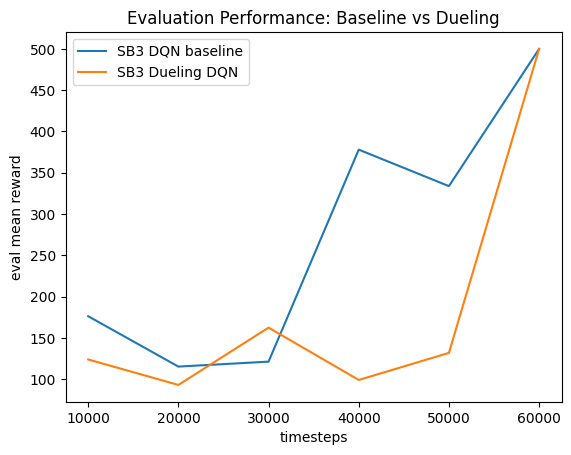

In [ ]:
def load_eval_npz(run_dir):
    npz_path = os.path.join(run_dir, "evaluations.npz")
    if not os.path.exists(npz_path):
        return None
    data = np.load(npz_path)
    timesteps = data["timesteps"]
    results = data["results"]          # shape [n_evals, n_episodes]
    mean_reward = results.mean(axis=1)
    return pd.DataFrame({"timesteps": timesteps, "mean_reward": mean_reward})

b = load_eval_npz(sb3_baseline_dir)
d = load_eval_npz(sb3_dueling_dir)

plt.figure()
if b is not None:
    plt.plot(b["timesteps"], b["mean_reward"], label="SB3 DQN baseline")
if d is not None:
    plt.plot(d["timesteps"], d["mean_reward"], label="SB3 Dueling DQN")
plt.xlabel("timesteps")
plt.ylabel("eval mean reward")
plt.title("Evaluation Performance: Baseline vs Dueling")
plt.legend()
plt.show()

In [ ]:
import os
import imageio
import gymnasium as gym
import numpy as np

from stable_baselines3 import DQN

def record_sb3_rollout_mp4(
    model_zip_path: str,
    out_mp4_path: str,
    env_id: str = "CartPole-v1",
    n_steps: int = 600,          # 600 frames at 30 fps = 20 seconds
    fps: int = 30,
    deterministic: bool = True,
):
    os.makedirs(os.path.dirname(out_mp4_path), exist_ok=True)

    env = gym.make(env_id, render_mode="rgb_array")
    model = DQN.load(model_zip_path)

    obs, info = env.reset()
    frames = []

    for _ in range(n_steps):
        frame = env.render()
        frames.append(frame)

        action, _ = model.predict(obs, deterministic=deterministic)
        obs, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            obs, info = env.reset()

    env.close()

    imageio.mimsave(out_mp4_path, frames, fps=fps)
    return out_mp4_path


In [ ]:
baseline_mp4 = record_sb3_rollout_mp4(
    model_zip_path=os.path.join(sb3_baseline_dir, "best_model.zip"),
    out_mp4_path=os.path.join(sb3_baseline_dir, "videos_manual", "baseline.mp4"),
    n_steps=600,
    fps=30,
)

dueling_mp4 = record_sb3_rollout_mp4(
    model_zip_path=os.path.join(sb3_dueling_dir, "best_model.zip"),
    out_mp4_path=os.path.join(sb3_dueling_dir, "videos_manual", "dueling.mp4"),
    n_steps=600,
    fps=30,
)

baseline_mp4, dueling_mp4


/usr/local/lib/python3.12/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.12/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

('sb3_logs/dqn_baseline_seed0/videos_manual/baseline.mp4',
 'sb3_logs/dqn_dueling_seed0/videos_manual/dueling.mp4')

In [ ]:
from IPython.display import Video, display

display(Video(baseline_mp4, embed=True))
display(Video(dueling_mp4, embed=True))

### Checkpoint

**What happened?**


Dueling DQN learns faster at first because it can more easily estimate which states are good. But that same decomposition makes it more sensitive to noisy value estimates. Without Double DQN or careful tuning, those errors can compound and cause instability. Baseline DQN is slower but more robust here, which is why simple methods often outperform more advanced ones on small problems


### Double DQN

A common failure mode in value-based RL is **overestimation bias**.

Why?
- Q-values are learned estimates and are noisy.
- Taking `max_a Q(s,a)` tends to select actions with positive noise.

Baseline DQN target:
y = r + γ max_a' Qθ⁻(s', a')

Double DQN target (key idea: decouple selection and evaluation):
1) select action using online net:
   a* = argmax_a' Qθ(s', a')

2) evaluate that action using target net:
   y = r + γ Qθ⁻(s', a*)

This reduces maximization bias and often improves stability.

### TODO
- Implement Double DQN
- Plot evaluation of Baseline v. Dueling v. Double DQN
